<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
IN_COLAB = True

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  !git clone https://github.com/evillag/uncertainty_gan.git
  !mv uncertainty_gan/mcd .
  !mv uncertainty_gan/feature_densities .
  !mv uncertainty_gan/test_bench .
  %rm -rf uncertainty_gan/

  !git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
  !mv lhcb-rich-gan-uncertainty/experiments .
  !mv lhcb-rich-gan-uncertainty/src .
  %rm -rf lhcb-rich-gan-uncertainty/
  %rm -rf sample_data/
  %pip install tensorflow-addons

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Mounted at /content/drive
Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 177 (delta 14), reused 4 (delta 3), pack-reused 147
Receiving objects: 100% (177/177), 20.07 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Cloning into 'lhcb-rich-gan-uncertainty'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (210/210), 2.94 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (94/94), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

In [3]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Save results path
output_dir = 'results/'
if IN_COLAB:
  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

# Load data and Sample selection

In [4]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion_-_up_2016_.csv
	rich/pion2_-_up_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.253849744796753
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(947937, 3)
targets_train shape	(947937, 5)
feats_val shape  	(525006, 3)
targets_val shape	(525006, 5)



In [5]:
# Draw a sample of the datasets
x_sample, y_sample = subsample_dataset(dataset['feats_val'], dataset['targets_val'], SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape

(TensorShape([100000, 3]), TensorShape([100000, 5]))

# Model creation

In [6]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [7]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 18s 6ms/step


(100000, 5)

In [8]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)

### Plotting functions

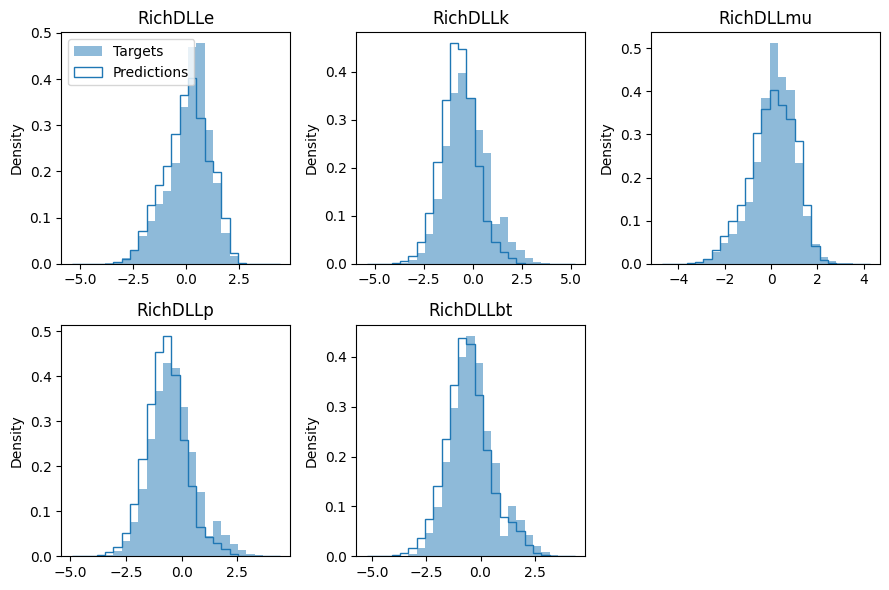

In [34]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [91]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None,
                                                 particle_index = 0, n_rows = 3, n_cols = 3, dll_columns=DLL_COLUMNS):
  n_rows, n_cols = 3, 3
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 2)

  js_distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

    js_dist = jensenshannon(predictions_hist, targets_hist)
    print('Jensen–Shannon distance:', js_dist)
    js_distances += [js_dist]

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  plt.show()

  return bin_edges, js_distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges[:-1], distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges[:-1], distances).rvalue)

## Monte Carlo Dropout method

In [11]:
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model

mcd_uncertainty = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0]
mcd_uncertainty.shape

Generating ensemble(300) predictions


100%|██████████| 300/300 [07:18<00:00,  1.46s/it]


TensorShape([100000, 5])

In [12]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_uncertainty)

### Plot MCD uncertainties

Jensen–Shannon distance: 0.2195610320261575
Jensen–Shannon distance: 0.2716245355160649
Jensen–Shannon distance: 0.157049064287843
Jensen–Shannon distance: 0.11568530124000954
Jensen–Shannon distance: 0.09876850840566563
Jensen–Shannon distance: 0.10078393622187529
Jensen–Shannon distance: 0.1209517941592551
Jensen–Shannon distance: 0.3437702222107756
Jensen–Shannon distance: 0.7446594546492765


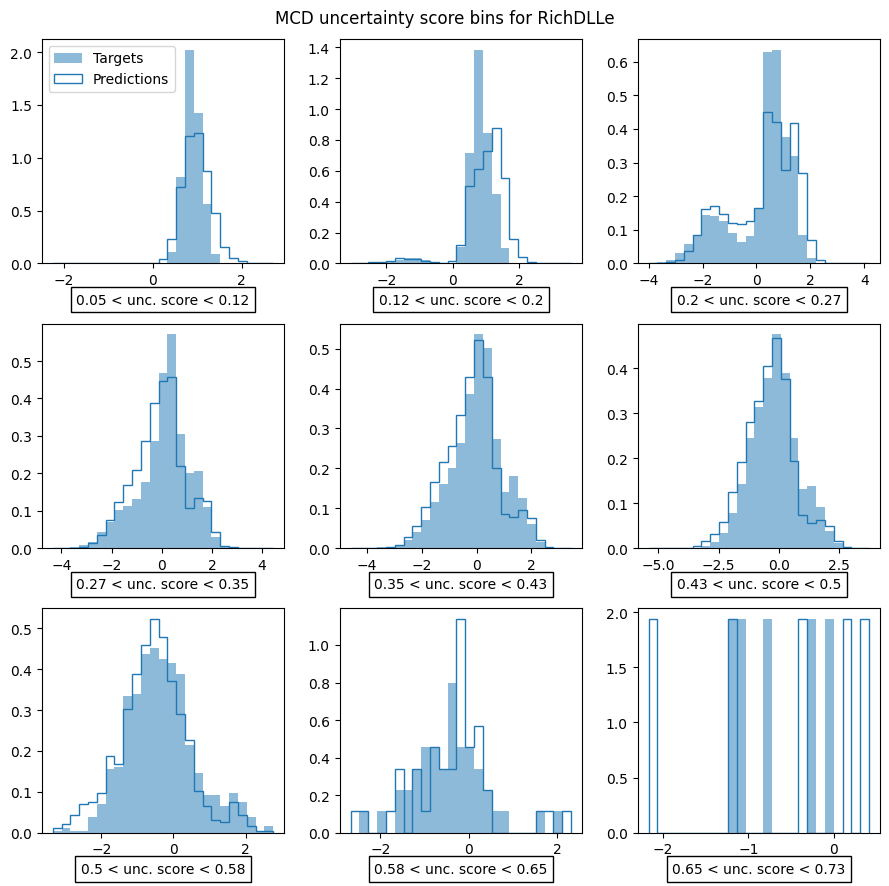

In [92]:
mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
    y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = 0)

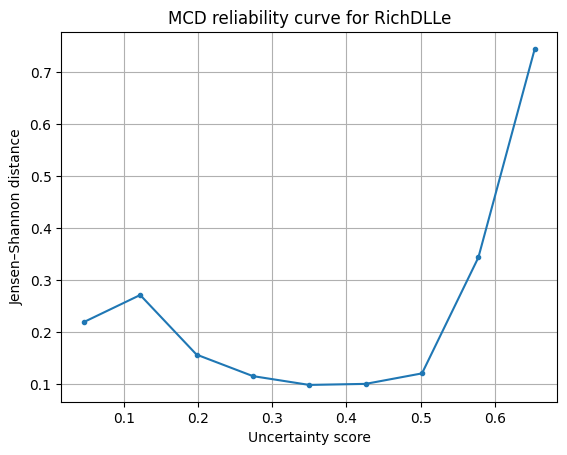

Correlation coefficient: 0.4917346083610168


In [94]:
plot_distances(mcd_bin_edges, mcd_js_distances, 'MCD')

## Feature Densities method

### Uncertainty estimation

In [16]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model

train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)


In [17]:
fd_uncertainty_normalized = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=1000,
                                              likelihood_method='normalized')[0]

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 11s 3ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [05:12<00:00,  2.44s/it]

Feature Densities using NORMALIZED uncertainty score for x_sample:


<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([0.84758396, 0.54482141, 0.3555435 , ..., 0.4818522 , 0.45687624,
       0.53882598])>

In [18]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

Plot FD uncertainties

Jensen–Shannon distance: 0.07118442180868567
Jensen–Shannon distance: 0.059798903078140425
Jensen–Shannon distance: 0.0810295539368048
Jensen–Shannon distance: 0.07935915989732345
Jensen–Shannon distance: 0.10408578387680849
Jensen–Shannon distance: 0.12278968897569534
Jensen–Shannon distance: 0.16402788287676803
Jensen–Shannon distance: 0.22121945537353987
Jensen–Shannon distance: 0.3398629347829282


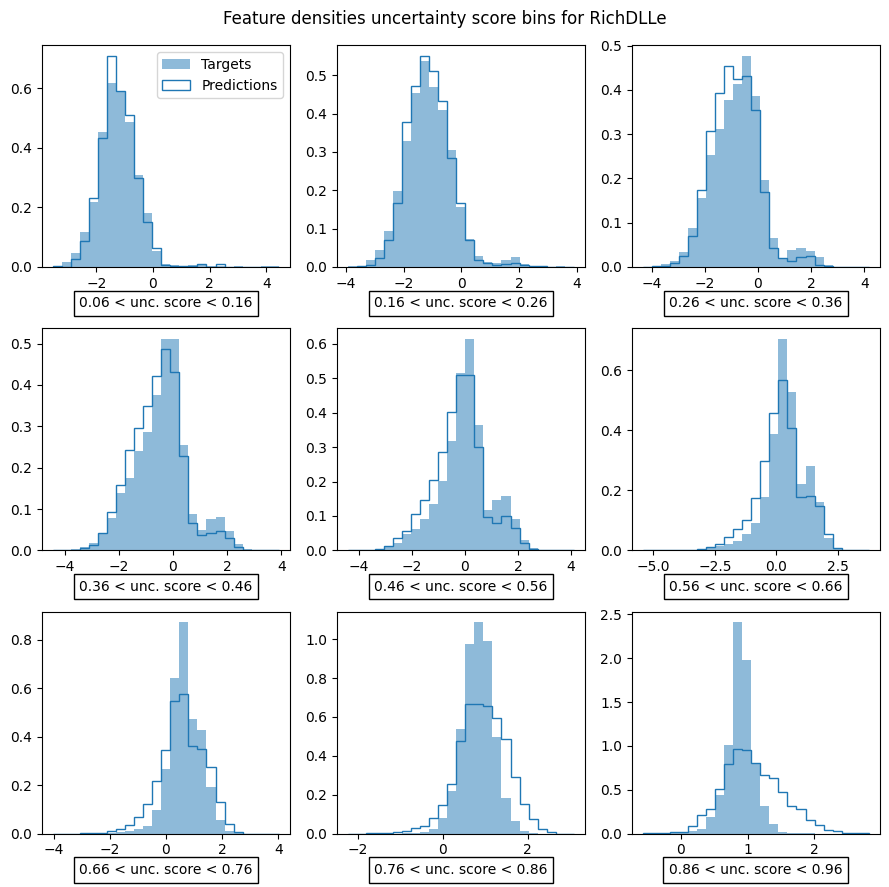

In [96]:
fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
    y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = 0, n_rows = 3, n_cols = 3)

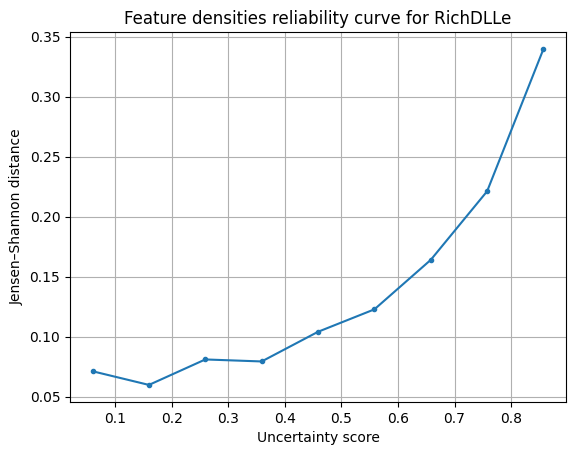

Correlation coefficient: 0.8820188898520255


In [97]:
plot_distances(fd_bin_edges, fd_js_distances, 'Feature densities')

## Uncertainty heat map

In [98]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

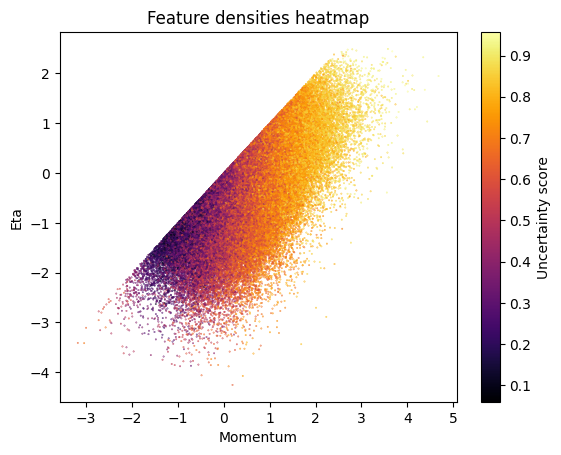

In [99]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [104]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

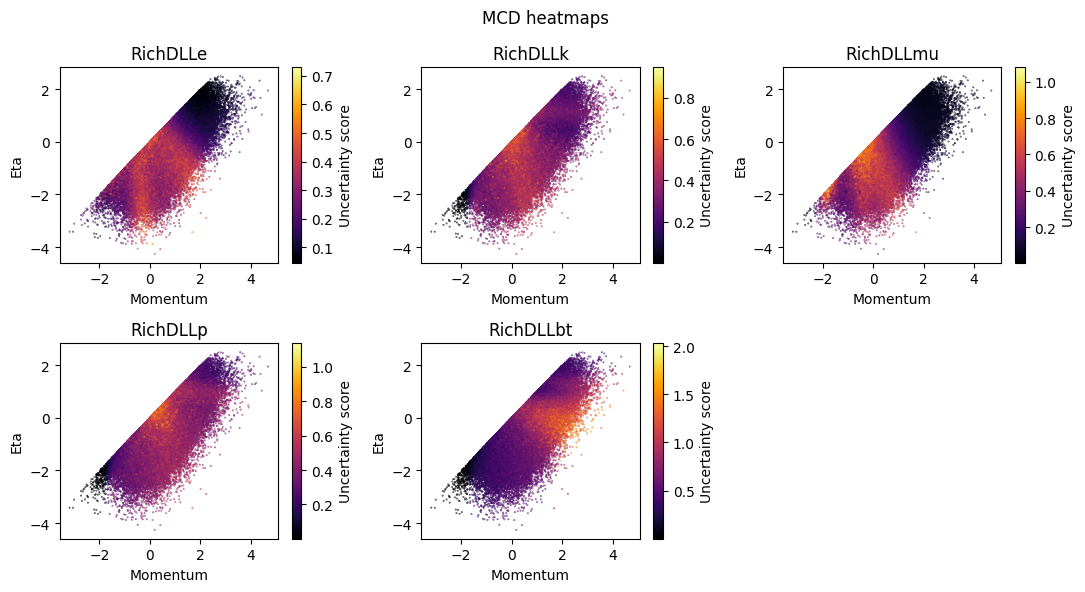

In [105]:
uncertainty_scatter_plot_mcd(x_sample, mcd_uncertainty)

# Archived

#### FD with integration method


In [ ]:
# fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, likelihood_method='integration')

# print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
# fd_uncertainty_integration

(948325, 128)
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample´s embeddings
2/2 [==============================] - 0s 6ms/step
Estimating sample´s feature densities


100%|██████████| 52/52 [10:21<00:00, 11.95s/it]

Feature Densities using INTEGRATION uncertainty score for x_sample:


<tf.Tensor: shape=(52,), dtype=float64, numpy=
array([0.99696795, 0.98386122, 0.9930798 , 0.99029255, 0.99388116,
       0.99106039, 0.98962542, 0.99185572, 0.98346811, 0.99297008,
       0.99250436, 0.99122989, 0.99037003, 0.97890695, 0.99057272,
       0.99336079, 0.98162482, 0.9881128 , 0.98746889, 0.99346868,
       0.99161914, 0.98390812, 0.98245716, 0.98058026, 0.97937096,
       0.99569436, 0.98796848, 0.9909012 , 0.98491409, 0.99193857,
       0.98075132, 0.99061284, 0.99276764, 0.98459823, 0.98762967,
       0.9787404 , 0.98669493, 0.98364207, 0.98975249, 0.98866702,
       0.99224149, 0.9924707 , 0.99271423, 0.99475767, 0.99674197,
       0.99607984, 0.99230945, 0.98954991, 0.99243532, 0.99160392,
       0.98236469, 0.98252359])>

In [ ]:
# Save FD uncertainties with integration
# np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)

In [ ]:
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])

In [ ]:
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

In [ ]:
# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)